# Workshop 3: Outlier detection

#### Descripition
This workshop aims to present an application of Gaussian mixture model probability distribution to detect outliers

**Course**: INF8111 - Fouille de données (Prof. Daniel Aloise, Summer 2019)

**Author**: Rodrigo Randel

## Imports

In [102]:
# http://www.numpy.org/
import numpy as np

# https://pandas.pydata.org
import pandas as pd

# https://matplotlib.org/
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# https://scikit-learn.org/stable/
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

#https://www.scipy.org
from scipy import stats
from scipy.stats import multivariate_normal

import math

## Loading data

In [118]:
# loading data
x = pd.read_csv('notes.csv', delimiter=',')
x.head(10)

,controle,final,tp1,tp2,tp3
0,17.3,18.5,95.0,100.0,88.50
1,16.0,18.8,95.0,91.5,86.50
2,17.3,18.0,90.0,97.0,84.00
3,12.5,20.0,95.0,86.4,91.35
4,15.5,18.0,95.0,93.4,94.00
5,18.5,16.5,95.0,86.4,91.35
6,14.0,18.9,90.0,86.0,77.00
7,18.5,16.0,90.0,97.0,84.00
8,16.0,16.5,95.0,100.0,88.50
9,16.0,16.0,98.0,93.0,100.00


## Visualizing the data in 2D

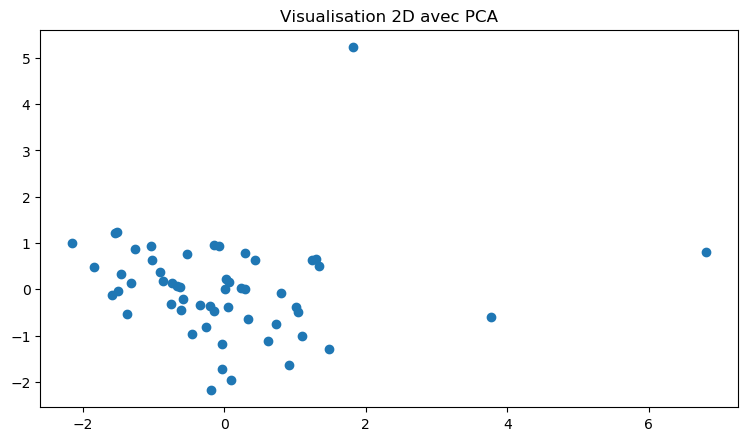

In [104]:
# normalization
x_std = StandardScaler().fit_transform(x)

# dimensionality reduction with PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_std)

# 2D plot
plt.figure(dpi=100, figsize=(9,5))
plt.scatter(x_pca[:, 0], x_pca[:, 1], cmap='viridis');
plt.title('Visualisation 2D avec PCA')
plt.show()

## Using Mixture of Gaussians to identify outliers

In [116]:
def probs(x, mu, sigma):
    """
    Compute P(x|mu, sigma) 
    """
    m_dist_x = np.dot((x-mu).transpose(),np.linalg.inv(sigma))
    m_dist_x = np.dot(m_dist_x, (x-mu))
    return 1-stats.chi2.cdf(m_dist_x, 2)

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance
       By Jake VanderPlas: https://github.com/jakevdp/PythonDataScienceHandbook
    """
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
def plot_gmm(X, n_comp=2, to_remove=None):
    """Visualize the locations and shapes of the GMM
       Adapted from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
    """
    if to_remove is not None:
        mask = np.ones(len(X), dtype=bool)
        mask[to_remove] = False
        X = X[mask,...]
    plt.figure(dpi=100, figsize=(9,5))
    plt.title(str(n_comp) + ' Mélange de gaussiennes ')
    ax = plt.gca()
    
    myc = ['b', 'r', 'c', 'm', 'y']
    gmm = GaussianMixture(n_components=n_comp, n_init=10).fit(X)
    labels = gmm.predict(X)
    
    probabilities = np.zeros((len(X), n_comp))
    for i in range(len(X)):
        probabilities[i] = [probs(X[i], gmm.means_[j], gmm.covariances_[j]) for j in range(n_comp)]
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', zorder=2)
    for i in range(len(X)):
        ax.annotate(str('%.1f' % probabilities[i][labels[i]]),(X[i,0], X[i,1]), size='xx-small')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor, color=myc[np.random.choice(len(myc))])
    
    return probabilities, labels

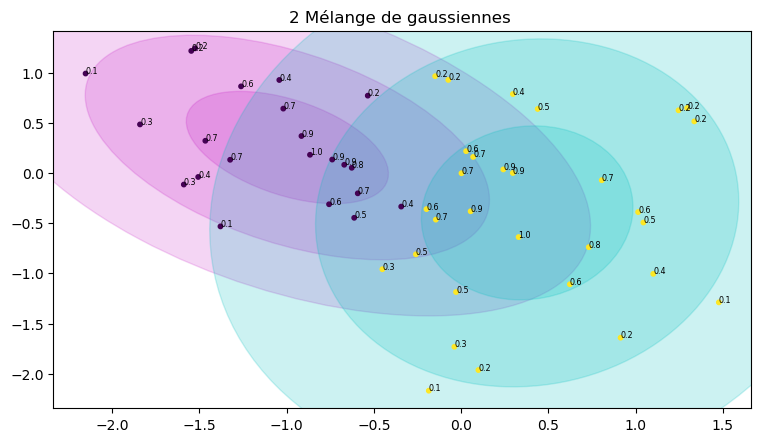

In [117]:
probabilities, labels = plot_gmm(X=x_pca, n_comp=2, to_remove=[51, 25, 54])

## Analyzing the probabilities

In [109]:
x['sum_probabilities'] = np.sum(probabilities, axis=1)
x.sort_values(by='sum_probabilities').head()

,controle,final,tp1,tp2,tp3,sum_probabilities
25,17.5,18.00,80.0,84.0,0.0,0.000003
51,9.5,11.00,0.0,64.6,69.0,0.000007
54,11.3,2.75,85.0,65.5,60.5,0.023826
52,15.0,0.00,98.0,93.0,100.0,0.128030
53,14.5,0.00,95.0,93.4,94.0,0.186552


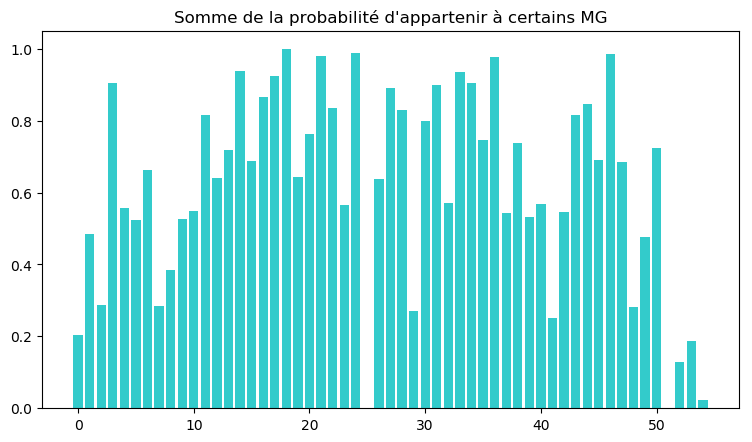

In [111]:
plt.figure(figsize=(9,5), dpi=100)
plt.bar(range(len(x)), x['sum_probabilities'], align='center', alpha=0.8, color='c')
plt.title('Somme de la probabilité d\'appartenir à certains MG')
plt.show()

## Using k-means

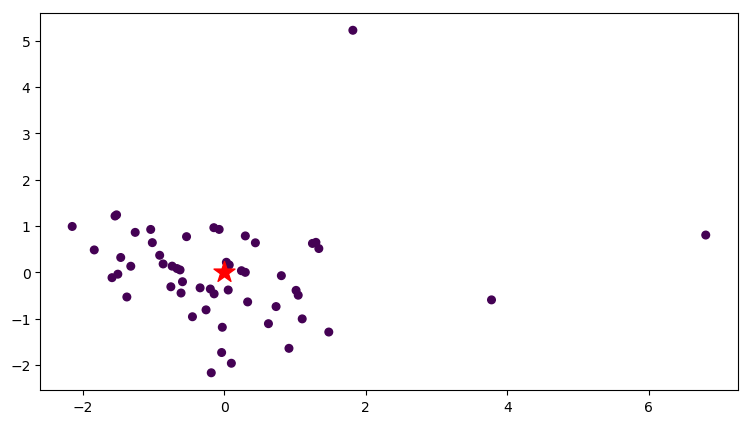

In [112]:
kmeans = KMeans(n_clusters=1).fit(x_pca)
labels_kmeans = kmeans.labels_
plt.figure(dpi=100, figsize=(9,5))
plt.scatter(x_pca[:,0], x_pca[:, 1], c=labels_kmeans, s=30)
for i in range(len(kmeans.cluster_centers_)):
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='*', c='r', s=250)

In [113]:
x['squared_error'] = [euclidean_distances(x_pca[i].reshape(1,2), kmeans.cluster_centers_[labels_kmeans[i]].reshape(1,2), squared=True)[0][0] for i in range(len(x_pca))]
x.sort_values(by='squared_error', ascending=False).head(10)

,controle,final,tp1,tp2,tp3,sum_probabilities,squared_error
51,9.5,11.00,0.0,64.6,69.0,0.000007,46.984864
25,17.5,18.00,80.0,84.0,0.0,0.000003,30.649201
54,11.3,2.75,85.0,65.5,60.5,0.023826,14.621774
0,17.3,18.50,95.0,100.0,88.5,0.203766,5.614306
52,15.0,0.00,98.0,93.0,100.0,0.128030,4.739668
2,17.3,18.00,90.0,97.0,84.0,0.287938,3.872736
7,18.5,16.00,90.0,97.0,84.0,0.284939,3.868780
53,14.5,0.00,95.0,93.4,94.0,0.186552,3.863883
48,9.8,9.50,85.0,81.9,85.0,0.280815,3.841090
8,16.0,16.50,95.0,100.0,88.5,0.385781,3.620725
